In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

# Set the path as tangible
os.chdir('..')

# Check current path 
print(os.getcwd())
# Visualization
from src.visualization import plot_categorical_distribution, plot_numerical_distribution, plot_crosstab, plot_scatter, plot_frequency_bar, plot_frequency_heatmap, create_frequency_bar_tangible, create_table, create_striped_table, plot_box_high_contrast


c:\Users\musta\Documents\Python Projects\tangible


In [2]:
# Read the text file
file_path = 'data/contractions/sayi_11.txt'
base_name = os.path.basename(file_path)
document_name = os.path.splitext(base_name)[0]
print("Document: " + document_name)

with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()


Document: sayi_11


In [3]:
# Metin Temizleme ve Tokenizasyon
# 1) Küçük harfe dönüştür
text = text.lower()

# 2) Noktalama işaretlerini sil (regex ile)
text = re.sub(r'[^\w\s]', '', text)

# 3) Sayı vb. temizle
text = re.sub(r'\d+', '', text)

# Tokenization
tokens = text.split()  # Boşluk karakterine göre ayırır


In [ ]:
# Türkçe sözlük dosyası kullanarak metin temizliği yap
# Türkçe sözlüğü yükle
turkish_dict_path = 'data/contractions/tr_isim_sifat.csv'
df_turkish_dict = pd.read_csv(turkish_dict_path)

# 1) form2 sütunundaki boş hücreleri "" ile doldur
df_turkish_dict['form2'] = df_turkish_dict['form2'].fillna("")

# 2) Sadece küçük harfe dönüştürerek kelimeleri kümeye ekle
turkish_words = set()
"""
for col in ['form1', 'form2']:
    # Küçük harfe dönüştür ve kümeye ekle
    turkish_words.update(df_turkish_dict[col].str.lower().tolist())
"""
for col in ['form1', 'form2']:
    # Küçük harfe dönüştür, regex ile özel karakterleri temizle ve kümeye ekle
    turkish_words.update(
        df_turkish_dict[col]
        .str.lower()  # Küçük harfe dönüştür
        .str.replace(r'[^a-zâçğıöşü\s]', '', regex=True)  # Sadece harf ve boşlukları bırak
        .dropna()  # Boş değerleri çıkar
        .tolist()  # Listeye dönüştür
    )

# Boş değerleri kümeden çıkar (eğer varsa)
turkish_words.discard("")
df_turkish_words = pd.DataFrame(list(turkish_words), columns=['word'])
df_turkish_words = df_turkish_words.sort_values('word', ascending=True)
print(df_turkish_words[df_turkish_words['word'].str.startswith('glâ')])
print(df_turkish_words)
# İlk 10 kelimeyi yazdır

#print("Türkçe sözlükteki ilk 10 kelime:", list(turkish_words)[:10])
#print(df_turkish_words)

# -- Metni temizleme ve tokenize etme --
text_path = 'data/contractions/sayi_11.txt'
with open(text_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 1) Küçük harfe dönüştür
text = text.lower()

# 2) Noktalama işaretlerini sil
text = re.sub(r'[^\w\sâçğıöşü]', '', text)

# 3) Sayıları temizle
text = re.sub(r'\d+', '', text)

# 4) Tokenizasyon
tokens = text.split()  # Boşluklara göre sözcükleri ayır

# 5) Türkçe sözlükte olmayan sözcükleri çıkar
filtered_tokens = [word for word in tokens if word in turkish_words]

# Sonuçları birleştir
#cleaned_text = ' '.join(filtered_tokens)
df_cleaned_text = pd.DataFrame(list(filtered_tokens), columns=['word'])
df_cleaned_text['count'] = 1
df_cleaned_text_word_counts = df_cleaned_text.groupby('word')['count'].sum().reset_index()
df_cleaned_text_word_counts = df_cleaned_text_word_counts.sort_values('count', ascending=False)

# Temizlenmiş metni yazdır
#print("Temizlenmiş metin:", cleaned_text)
print(df_cleaned_text_word_counts)
print(df_cleaned_text_word_counts[df_cleaned_text_word_counts['word'].str.startswith('daha')])


             word
896      glâsnost
29359   glâsyolog
36773  glâsyoloji
2832       glâyöl
                  word
34179         başpapaz
36866            böyle
42939   dinamit lokumu
37255           dördüz
393           dışlanma
...                ...
4435         şırıldama
16009          şırıltı
23427          şırınga
25877           şıvgın
6973        şığa göçüm

[42992 rows x 1 columns]
        word  count
119      bir    302
780       ve    184
133       bu    138
171       de     95
548       ne     68
..       ...    ...
897       ün      1
899    ünsüz      1
895  öğretim      1
17     allah      1
20    alıntı      1

[932 rows x 2 columns]
     word  count
159  daha     21


In [ ]:
# Hunspell Türkçe sözlüğü yükle (CSV dosyasından)
turkish_dict_path = 'data/contractions/hunspell_tr.csv'
df_turkish_dict = pd.read_csv(turkish_dict_path, header=None, names=["word"])

# 1) Boş değerleri çıkar ve küçük harfe dönüştür
df_turkish_dict['word'] = df_turkish_dict['word'].str.strip().str.lower()
df_turkish_dict = df_turkish_dict.dropna()  # Boş satırları sil

# 2) Kelimeleri kümeye ekle
turkish_words = set(df_turkish_dict['word'].tolist())

# Boş değerleri kümeden çıkar (eğer varsa)
turkish_words.discard("")  # Herhangi bir boş kelime varsa çıkar

# 3) Sözlüğü DataFrame olarak sıralayıp inceleyin
df_turkish_words = pd.DataFrame(list(turkish_words), columns=['word'])
df_turkish_words = df_turkish_words.sort_values('word', ascending=True)

# Sözlükte "kâ" ile başlayan kelimeleri yazdır
#print(df_turkish_words[df_turkish_words['word'].str.startswith('kâ')])

# Tüm sözlüğü yazdır
#print(df_turkish_words)

# -- Metni temizleme ve tokenize etme --
text_path = 'data/contractions/sayi_11.txt'
with open(text_path, 'r', encoding='utf-8') as file:
    text = file.read()

# 1) Küçük harfe dönüştür
text = text.lower()

# 2) Noktalama işaretlerini sil
text = re.sub(r'[^\w\sçğıöşü]', '', text)

# 3) Sayıları temizle
text = re.sub(r'\d+', '', text)

# 4) Tokenizasyon
tokens = text.split()  # Boşluklara göre sözcükleri ayır

# 5) Sözlükteki kelimelerle başlayan sözcükleri kontrol et
def is_valid_word(word, dictionary):
    # Kelimenin sözlükteki herhangi bir kelimeyle başlayıp başlamadığını kontrol et
    for valid_word in dictionary:
        if word.startswith(valid_word):
            return True
    return False

filtered_tokens = [word for word in tokens if is_valid_word(word, turkish_words)]

# Sonuçları birleştir
df_cleaned_text = pd.DataFrame(list(filtered_tokens), columns=['word'])
df_cleaned_text['count'] = 1
df_cleaned_text_word_counts = df_cleaned_text.groupby('word')['count'].sum().reset_index()
df_cleaned_text_word_counts = df_cleaned_text_word_counts.sort_values('count', ascending=False)

# Temizlenmiş metni yazdır
print(df_cleaned_text_word_counts)
print(df_cleaned_text_word_counts[df_cleaned_text_word_counts['word'].str.startswith('daha')])


         word
29794  kâbusu
          word
51029       ab
43440      aba
72915     abac
20536   abajur
3193    abaküs
...        ...
8869     şırıl
25315   şırıld
44267  şırıltı
65559  şırınga
20382   şıvgın

[75908 rows x 1 columns]
             word  count
725           bir    302
4686           ve    184
813            bu    138
1061           de     95
1014           da     85
...           ...    ...
1007   cümlelerin      1
1008  cümlelerini      1
1009         cıla      1
5612    şükrettim      1
4912   yaşlarında      1

[5614 rows x 2 columns]


In [9]:
# Create data frame
df = pd.DataFrame(tokens, columns=['word'])
#df = pd.DataFrame(filtered_tokens, columns=['word'])
df['count'] = 1

# Gruplayarak frekans (count) değerini hesapla
word_counts = df.groupby('word')['count'].sum().reset_index()

# Dosya ismini ekle
#word_counts['source'] = document_name

# Frekansına göre büyükten küçüğe sırala

word_counts = word_counts.sort_values('count', ascending=False)

# İlk 20 kelimeyi görüntüleyelim
print(word_counts)
print(word_counts[word_counts['word'].str.startswith('daha')])


             word  count
731           bir    302
4692           ve    184
819            bu    138
1067           de     95
1020           da     85
...           ...    ...
1009  cümlelerden      1
1010    cümlelere      1
1011    cümleleri      1
5629    şükrettim      1
5615     şimdilik      1

[5631 rows x 2 columns]
      word  count
1021  daha     21


In [6]:
# CSV dosyasına kaydet
csv_path = 'data/contractions/word_frequencies_oe_cocuk.csv'
if not os.path.exists(csv_path):
    # CSV yoksa oluştur (header dahil)
    word_counts.to_csv(csv_path, index=False, encoding='utf-8')
else:
    # CSV varsa oku ve birleştir (append)
    existing_df = pd.read_csv(csv_path)
    combined_df = pd.concat([existing_df, word_counts], ignore_index=True)
    combined_df.to_csv(csv_path, index=False, encoding='utf-8')


In [ ]:
# Tekrar eden sözcükleri birleştir (Word Frequencies CSV dosyası için)
csv_path = 'data/contractions/word_frequencies.csv'
df = pd.read_csv(csv_path)

# Sözcük bazında topla
df_merged = df.groupby('word', as_index=False)['count'].sum()
df_merged = df_merged.sort_values('count', ascending=False)

# Eğer 'source' (belge adı) sütunu da varsa ve hem 'word' hem de 'source' bazında birleştirmek istiyorsanız:
# df_merged = df.groupby(['word', 'source'], as_index=False)['count'].sum()
# Ortalamayı ve standart sapmayı hesapla
mean_val = df_merged['count'].mean()
std_val = df_merged['count'].std()

# Standart sapmanın 0 olması ihtimaline karşı kontrol et
if std_val == 0:
    # Böyle bir durumda tüm z-skorları 0 yapılabilir
    df_merged['z_score'] = 0
else:
    # (count - ortalama) / std formülüyle z-skorunu ekle
    df_merged['z_score'] = (df_merged['count'] - mean_val) / std_val

# Sonucu incele
print(mean_val)
print(std_val)
print(df_merged)

# CSV olarak kaydet
#df_merged.to_csv('data/contractions/word_frequencies_merged.csv', index=False, encoding='utf-8')


In [ ]:
# Stopwords
import nltk

# Türkçe stopword'leri indirelim (bir kereye mahsus)
# nltk.download('stopwords')
from nltk.corpus import stopwords

# NLTK'nin Türkçe stopword'lerini alalım (tamamen yeterli olmayabilir, isteğe göre genişletilebilir)
#turkish_stopwords_nltk = stopwords.words('turkish')
turkish_stopwords_nltk = []
print(turkish_stopwords_nltk)
# Ek olarak kendi özel stopword listenizi de tanımlayabilirsiniz
csv_path_stopwords = 'data/contractions/stopwords.csv'
df_my_stopwords = pd.read_csv(csv_path_stopwords, header=None)
my_stopwords = df_my_stopwords[0].tolist()
# İki listeyi birleştirelim

turkish_stopwords = set(turkish_stopwords_nltk + my_stopwords)

# --- Asıl analiz ---

# 1) CSV'yi okuyalım
csv_path = 'data/contractions/word_frequencies.csv'
df = pd.read_csv(csv_path)

# 2) Sözcük bazında topla (aynı 'word' birden çok satırda olabilir diye)
df_merged = df.groupby('word', as_index=False)['count'].sum()

# 3) Stopword’leri çıkaralım
df_stopwords_removed = df_merged[~df_merged['word'].isin(turkish_stopwords)]

# 4) Temizlenmiş veriyi frekansa göre sırala
df_stopwords_removed = df_stopwords_removed.sort_values('count', ascending=False).reset_index(drop=True)
#df_stopwords_removed = df_stopwords_removed.sort_values('word', ascending=True).reset_index(drop=True)

# 5) Ortalamayı ve standart sapmayı hesaplayalım
mean_val_sw = df_stopwords_removed['count'].mean()
std_val_sw = df_stopwords_removed['count'].std()

# 6) Z-skorunu hesapla
if std_val_sw == 0:
    df_stopwords_removed['z_score'] = 0
else:
    df_stopwords_removed['z_score'] = (df_stopwords_removed['count'] - mean_val_sw) / std_val_sw

# 7) Sonucu görelim
print(mean_val_sw)
print(std_val_sw)
print(df_stopwords_removed.head(20))

# 8) İsterseniz CSV olarak kaydedebilirsiniz
# df_stopwords_removed.to_csv('data/contractions/word_frequencies_merged_no_stopwords.csv', 
#                             index=False, encoding='utf-8')


Toplam sözcük: 280161
Toplam frekans: 20478
BHK sayısı: 28
Ortalama: 731.3571428571429
Standart sapma: 584.2480583200887
Skewness: 0.5732847221094318


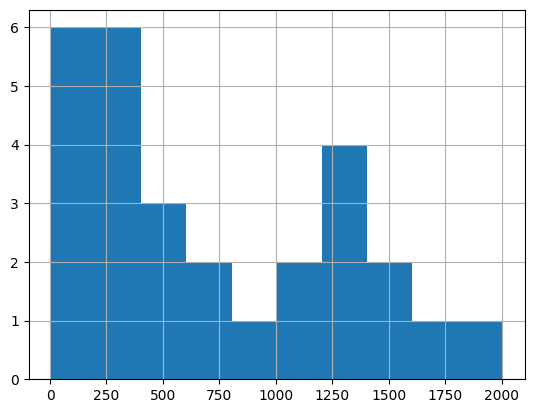

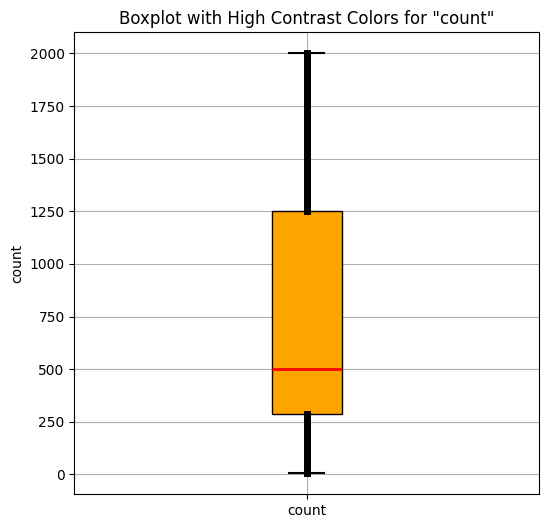

In [ ]:
# Bir Harfli Kısaltmalar: Z-Skoru

# CSV'yi oku
csv_path = 'data/contractions/word_frequencies_novels.csv'
df_single = pd.read_csv(csv_path)

# Tek harfli kısaltmalar listesi
csv_path_con_single = 'data/contractions/con_single.csv'
df_con_single = pd.read_csv(csv_path_con_single, header=None)
contractions_list_single = df_con_single[0].tolist()

# Stopwordleri çıkar
csv_path_stopwords_single = 'data/contractions/stopwords_single.csv'
df_my_stopwords_single = pd.read_csv(csv_path_stopwords_single, header=None)
my_stopwords_single = df_my_stopwords_single[0].tolist()
df_single = df_single[~df_single['word'].isin(my_stopwords_single)]
#print(df_single)
print(f"Toplam sözcük: {df_single['count'].sum()}")

# 1) Listedeki sözcüklerle BAŞLAYAN tüm sözcüklerin toplam frekansını hesapla
results = []
for cword in contractions_list_single:
    sub_count = df_single[df_single['word'].str.startswith(cword, na=False)]['count'].sum()

    # Ünsüz yumuşamasına uğramış sözcükler varsa
    if cword == "büyük":
        sub_count += df_single[df_single['word'].str.startswith("büyüğ", na=False)]['count'].sum()
    elif cword == "artık":
        sub_count += df_single[df_single['word'].str.startswith("artığ", na=False)]['count'].sum()

    results.append({'word': cword, 'count': sub_count})

df_single_freq = pd.DataFrame(results)
#print(df_single_freq)
print(f"Toplam frekans: {df_single_freq['count'].sum()}")
# 2) Ortalamayı ve standart sapmayı hesapla
mean_val_single = df_single_freq['count'].mean()
std_val_single = df_single_freq['count'].std()

# 3) Standart sapmanın 0 olması ihtimaline karşı kontrol yap
if std_val_single == 0:
    # Böyle bir durumda tüm z-skorlarını 0 yap
    df_single_freq['z_score'] = 0
else:
    # (count - ortalama) / std formülüyle z-skorunu ekleyelim
    df_single_freq['z_score'] = (df_single_freq['count'] - mean_val_single) / std_val_single

# 4) Log-Transfer uygula

# 'count' değerleri için log(1+x) dönüşümü
df_single_freq['log_count'] = np.log1p(df_single_freq['count'])  # log(count + 1)

# 5) Log değerlerin ortalamasını ve std'sini alın
mean_log = df_single_freq['log_count'].mean()
std_log = df_single_freq['log_count'].std()

# 6) Log değer üzerinden z-skoru
if std_log == 0:
    df_single_freq['z_score_log'] = 0
else:
    df_single_freq['z_score_log'] = (df_single_freq['log_count'] - mean_log) / std_log

# 7) Z-Skoruna göre kategorilere ayır
# Kategoriler için bin aralıkları (soldan sağa sıralı):
bins = [-np.inf, -1, -0.5, 0, 0.5, 1, np.inf]
# Bu aralıklara denk gelen etiketler (labels):
labels = ["çok düşük", "düşük", "orta düşük", "orta yüksek", "yüksek", "çok yüksek"]
df_single_freq['z_categories'] = pd.cut(df_single_freq['z_score'], bins=bins, labels=labels)

# 8) Yüzdelik hesapla
# Toplam 'count' değerini hesapla
total_count_single = df_single_freq['count'].sum()
# Yeni sütun: 'percentage' (yüzde)
df_single_freq['percentage'] = (df_single_freq['count'] / total_count_single) * 100
df_single_percent = df_single_freq[['word', 'count', 'percentage', 'z_score', 'z_score_log', 'z_categories']]

# 9) Sırala ve sonucu yazdır
df_single_freq = df_single_freq.sort_values("count", ascending=False).reset_index(drop=True)
#print(df_single_freq)
df_single_percent = df_single_percent.sort_values("count", ascending=False).reset_index(drop=True)
print(f"BHK sayısı: {df_single_percent['word'].size}")
print(f"Ortalama: {mean_val_single}")
print(f"Standart sapma: {std_val_single}")
#print(df_single_percent)
# Çok düşük olanları sırala
print(f"Skewness: {df_single_percent['count'].skew()}")
#print(df_single_percent[df_single_percent['z_categories'] == 'düşük'])
#print(df_single_percent[df_single_percent['word'] == 'büyük'])
# Histogram ve Boxplot
df_single_percent['count'].hist()
plt.show()
#df_single_percent.boxplot(column='count')
#plt.show()
plot_box_high_contrast(
    df_single_percent)

In [2]:
# İki Harfli Kısaltmalar: Z-Skoru

# CSV'yi oku
csv_path = 'data/contractions/word_frequencies.csv'
df = pd.read_csv(csv_path)

# İki harfli kısaltmalar listesi
csv_path_con_double = 'data/contractions/con_double.csv'
df_con_double = pd.read_csv(csv_path_con_double, header=None)
# 2. sütundaki değerleri listeye al
contractions_double = df_con_double[1].tolist()
print(contractions_double)

# 1) Listedeki her sözcükle BAŞLAYAN tüm sözcüklerin toplam frekansını bulalım
results = []
for cword in contractions_double:
    sub_count = df[df['word'].str.startswith(cword, na=False)]['count'].sum()
    # Ünsüz yumuşaması varsa frekansa ekle
    if cword == "cevap":
        sub_count += df[df['word'].str.startswith("cevab", na=False)]['count'].sum()
    elif cword == "çeşit":
        sub_count += df[df['word'].str.startswith("çeşid", na=False)]['count'].sum()
    elif cword == "çocuk":
        sub_count += df[df['word'].str.startswith("çocuğ", na=False)]['count'].sum()
    elif cword == "kitap":
        sub_count += df[df['word'].str.startswith("kitab", na=False)]['count'].sum()
    elif cword == "küçük":
        sub_count += df[df['word'].str.startswith("küçüğ", na=False)]['count'].sum()
    elif cword == "sebep":
        sub_count += df[df['word'].str.startswith("sebeb", na=False)]['count'].sum()
    elif cword == "sıcak":
        sub_count += df[df['word'].str.startswith("sıcağ", na=False)]['count'].sum()
    elif cword == "soğuk":
        sub_count += df[df['word'].str.startswith("soğuğ", na=False)]['count'].sum()
    elif cword == "toprak":
        sub_count += df[df['word'].str.startswith("toprağ", na=False)]['count'].sum()
    # Ünlü düşmesi varsa frekansa ekle
    elif cword == "cisim":
        sub_count += df[df['word'].str.startswith("cism", na=False)]['count'].sum()
    elif cword == "kısım":
        sub_count += df[df['word'].str.startswith("kısm", na=False)]['count'].sum()

    results.append({'word': cword, 'count': sub_count})

df_double_freq = pd.DataFrame(results)

# 2) Ortalamayı ve standart sapmayı hesapla
mean_val_double = df_double_freq['count'].mean()
std_val_double = df_double_freq['count'].std()

# 3) Standart sapmanın 0 olması ihtimaline karşı kontrol yap
if std_val_double == 0:
    df_double_freq['z_score'] = 0
else:
    # (count - ortalama) / std formülüyle z-skorunu ekleyelim

    df_double_freq['z_score'] = (df_double_freq['count'] - mean_val_double) / std_val_double

# 4) Log-Transfer uygula
# 'count' değerleri için log(1+x) dönüşümü
df_double_freq['log_count'] = np.log1p(df_double_freq['count'])  # log(count + 1)

# 5) Log değerlerin ortalamasını ve std'sini alın
mean_double_log = df_double_freq['log_count'].mean()
std_double_log = df_double_freq['log_count'].std()

# 6) Log değer üzerinden z-skoru
if std_double_log == 0:
    df_double_freq['z_score_log'] = 0
else:
    df_double_freq['z_score_log'] = (df_double_freq['log_count'] - mean_double_log) / std_double_log

# 7) Z-Skoruna göre kategorilere ayır
# Kategoriler için bin aralıkları (soldan sağa sıralı):
bins = [-np.inf, -1, -0.5, 0, 0.5, 1, np.inf]
# Bu aralıklara denk gelen etiketler (labels):
labels = ["çok düşük", "düşük", "orta düşük", "orta yüksek", "yüksek", "çok yüksek"]
df_double_freq['z_categories'] = pd.cut(df_double_freq['z_score_log'], bins=bins, labels=labels)

# 8) Yüzdelik hesapla
# Toplam 'count' değerini hesapla
total_count_double = df_double_freq['count'].sum()
# Yeni sütun: 'percentage' (yüzde)
df_double_freq['percentage'] = (df_double_freq['count'] / total_count_double) * 100
df_double_percent = df_double_freq[['word', 'count', 'percentage', 'z_score_log', 'z_categories']]


# 9) Sırala ve sonucu yazdır
df_double_percent = df_double_percent.sort_values("count", ascending=False).reset_index(drop=True)
print(mean_val_double)
print(std_val_double)
#print(df_double_percent)
# Çok düşük olanları sırala
print(df_double_percent[df_double_percent['z_categories'] == 'çok yüksek'])
#print(df_double_percent[df_double_percent['word'] == 'küçük'])


FileNotFoundError: [Errno 2] No such file or directory: 'data/contractions/word_frequencies.csv'